In [2]:
import numpy as np
import pandas as pd
from plotnine import *

/tmp/ipykernel_808605/4134983968.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Regression review

Suppose we have a data set with five predictors, X1 = GPA, X2 = IQ, X3 = Level (1 for College and 0 for High School), X4 = Interaction between GPA and IQ, and X5 = Interaction between GPA and Level. 

The response is starting salary after graduation (in thousands of dollars). 

Suppose we use least squares to fit the model, and get 
- $\hat{\beta}_0 = 50$
- $\hat{\beta}_1 = 20$
- $\hat{\beta}_2 = 0.07$
- $\hat{\beta}_3 = 35$
- $\hat{\beta}_4 = 0.01$
- $\hat{\beta}_5 = -10$


(a) Which answer is correct, and why?
i. For a fixed value of IQ and GPA, high school graduates earn more, on average, than college graduates.
ii. For a fixed value of IQ and GPA, college graduates earn more, on average, than high school graduates.
iii. For a fixed value of IQ and GPA, high school graduates earn more, on average, than college graduates provided that the GPA is high enough.
iv. For a fixed value of IQ and GPA, college graduates earn more, on average, than high school graduates provided that the GPA is high enough.

In [3]:
### 2 because iq and gpa are fixed, we simply compare the level var
### which has a parameter value of 35, meaning there is a significant impact to changing it.




(b) Predict the salary of a college graduate with IQ of 115 and a GPA of 4.0.


In [4]:
def model(x1, x2, x3):
    betas = (50, 20, 0.07, 35, 0.01, -10)
    xs = (1, x1, x2, x3, x1*x2, x1*x3)
    return sum(beta*x for beta, x in zip(betas, xs)) * 1e3

model(4.0, 115, 1)

137650.0


(c) True or false: Since the coefficient for the GPA/IQ interaction term is very small, there is very little evidence of an interaction effect. Justify your answer.

In [5]:
# false for gpa, true for iq. At least given the data to create this model, IQ has a marginal influence in comparison to other factors like gpa and level. 
# In fact, the iq coefficient is 3 orders of magnitude less than the gpa or level term. 

## Power output

The file ```CCPP.xlsx``` contains 9568 data points collected from a Combined Cycle Power Plant over 6 years (2006-2011), when the power plant was set to work with full load. 

Features consist of hourly average ambient variables Temperature (T), Ambient Pressure (AP), Relative Humidity (RH) and Exhaust Vacuum (V) to predict the net hourly electrical energy output (EP) of the plant. A combined cycle power plant (CCPP) is composed of gas turbines (GT), steam turbines (ST) and heat recovery steam generators. 

In a CCPP, the electricity is generated by gas and steam turbines, which are combined in one cycle, and is transferred from one turbine to another, while the Vacuum is collected from and has effect on the Steam Turbine, the other three of the ambient variables effect the GT performance.

In this problem we will ask whether linear regression models might be used to predict the electrical energy output of the plant.

The data here are presented as unnormalized.  Let's first use exploratory data analysis to take a look at the plant's data.

a.  Calculate summary statistics and histograms for each of the 4 potential explanatory variables.

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 31'. Pick better value with 'binwidth'.


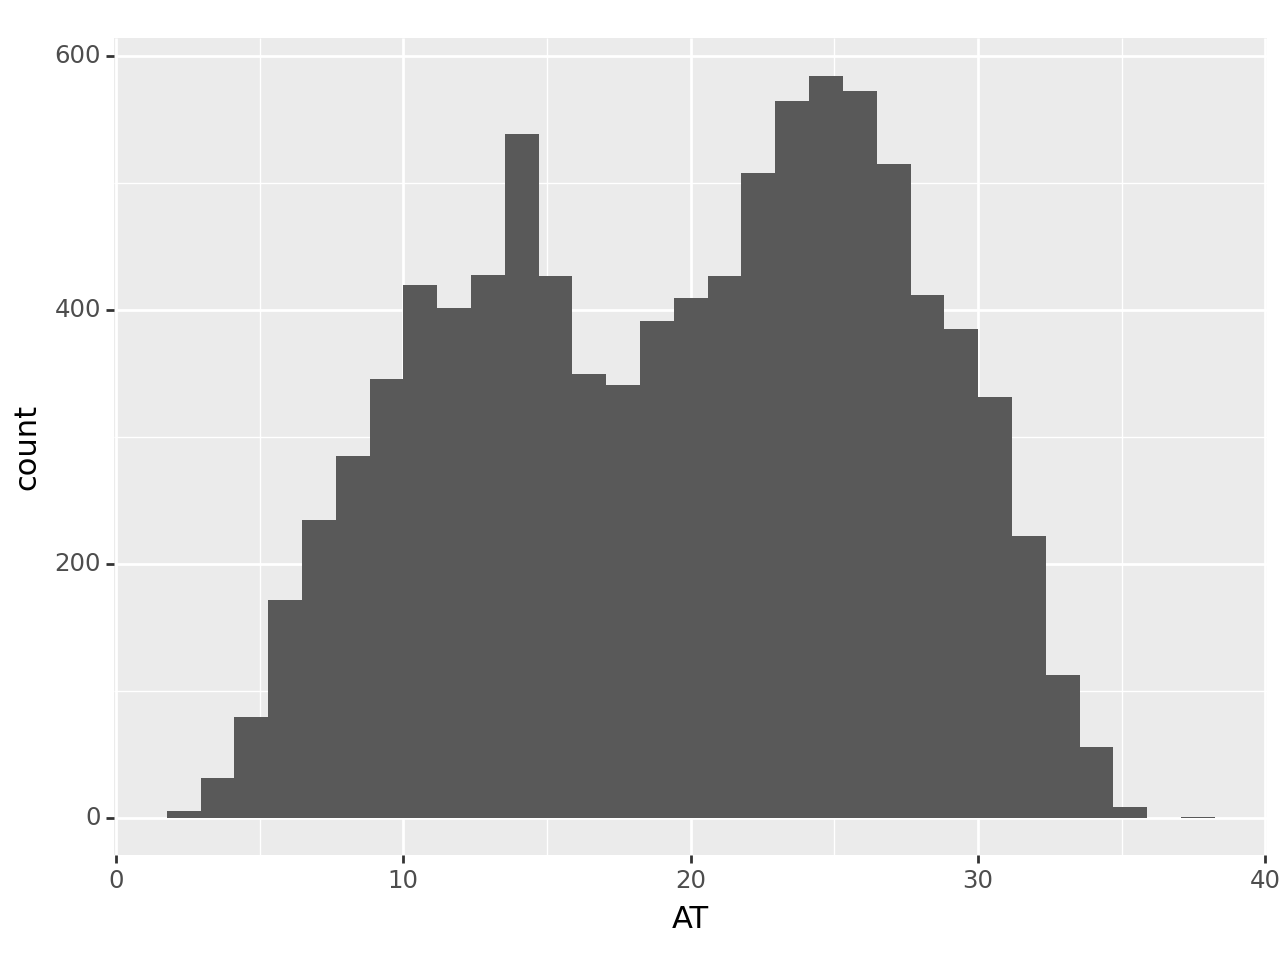

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 25'. Pick better value with 'binwidth'.


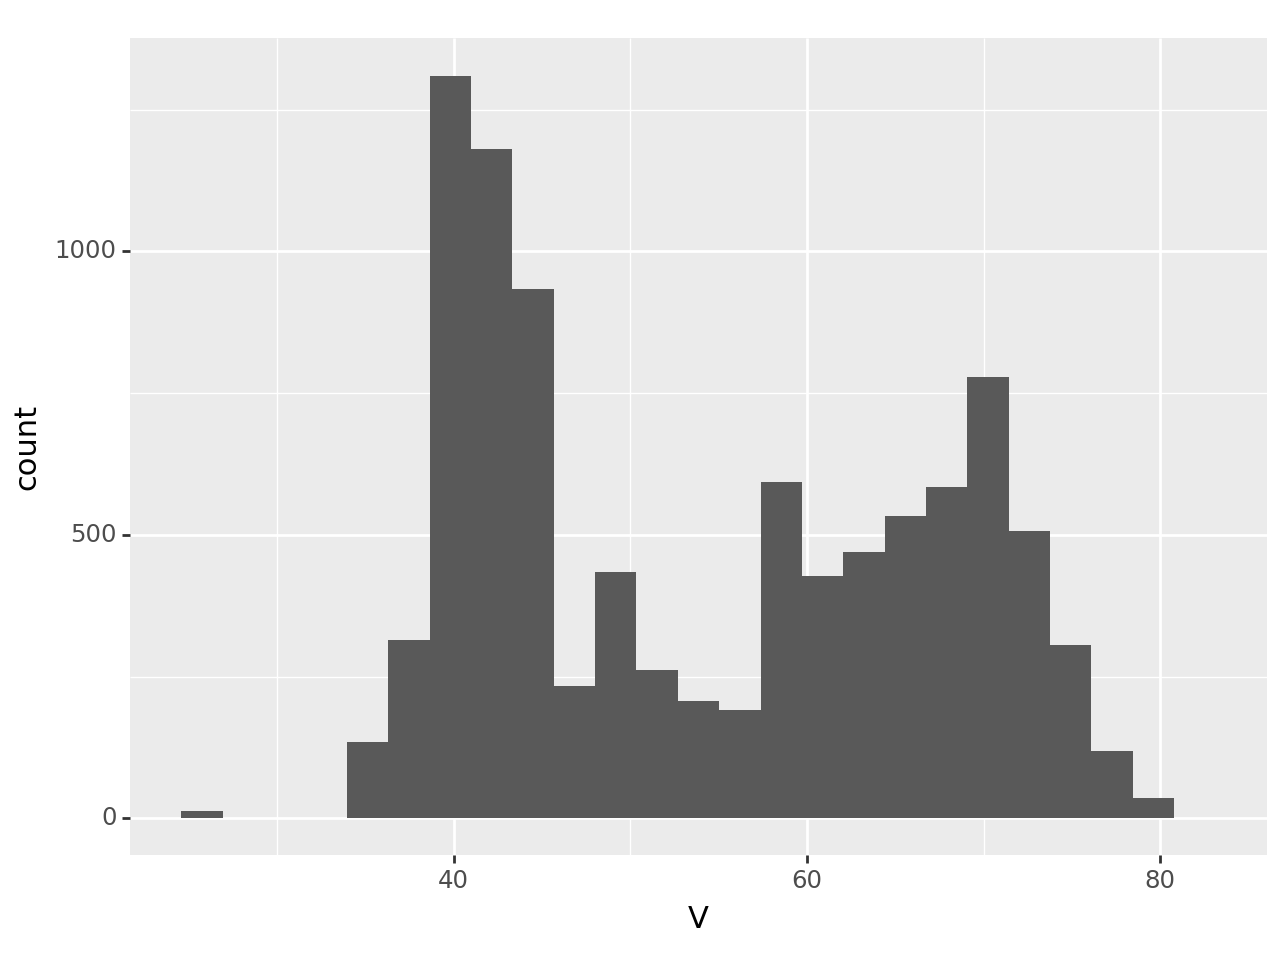

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 53'. Pick better value with 'binwidth'.


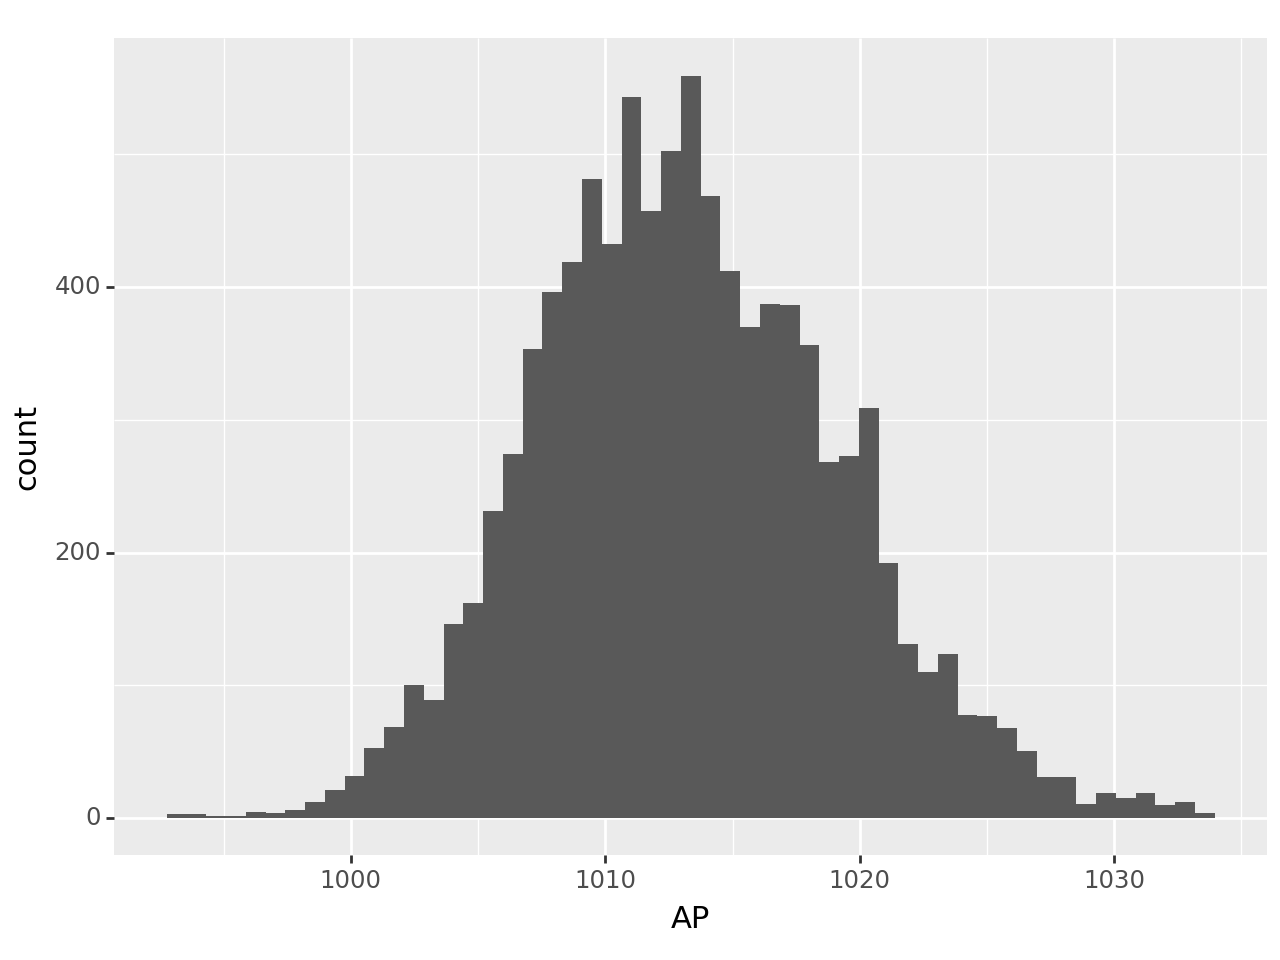

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 37'. Pick better value with 'binwidth'.


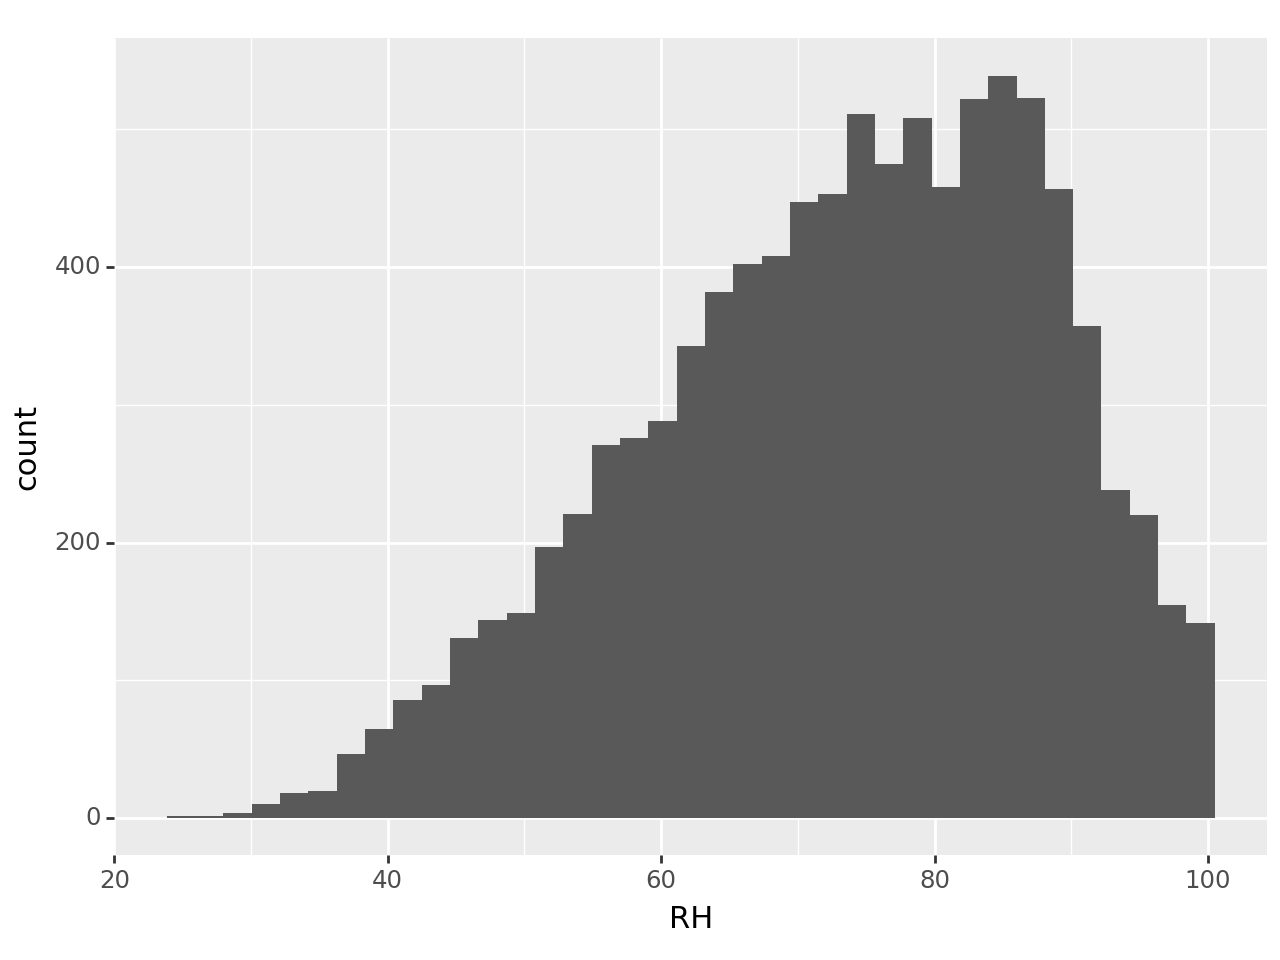

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [390]:
ccpp = pd.read_excel("CCPP_data.xlsx")
columns = ccpp.columns[:-1]
plots = [None]*len(columns)
for i, col in enumerate(columns):
    plots[i] = (
        ggplot(ccpp) +
        aes(x=col) +
        geom_histogram()
    )
plots

b. Use a scatterplot to look at the relationship between each of the variables and the output.  Do any of them seem correlated?

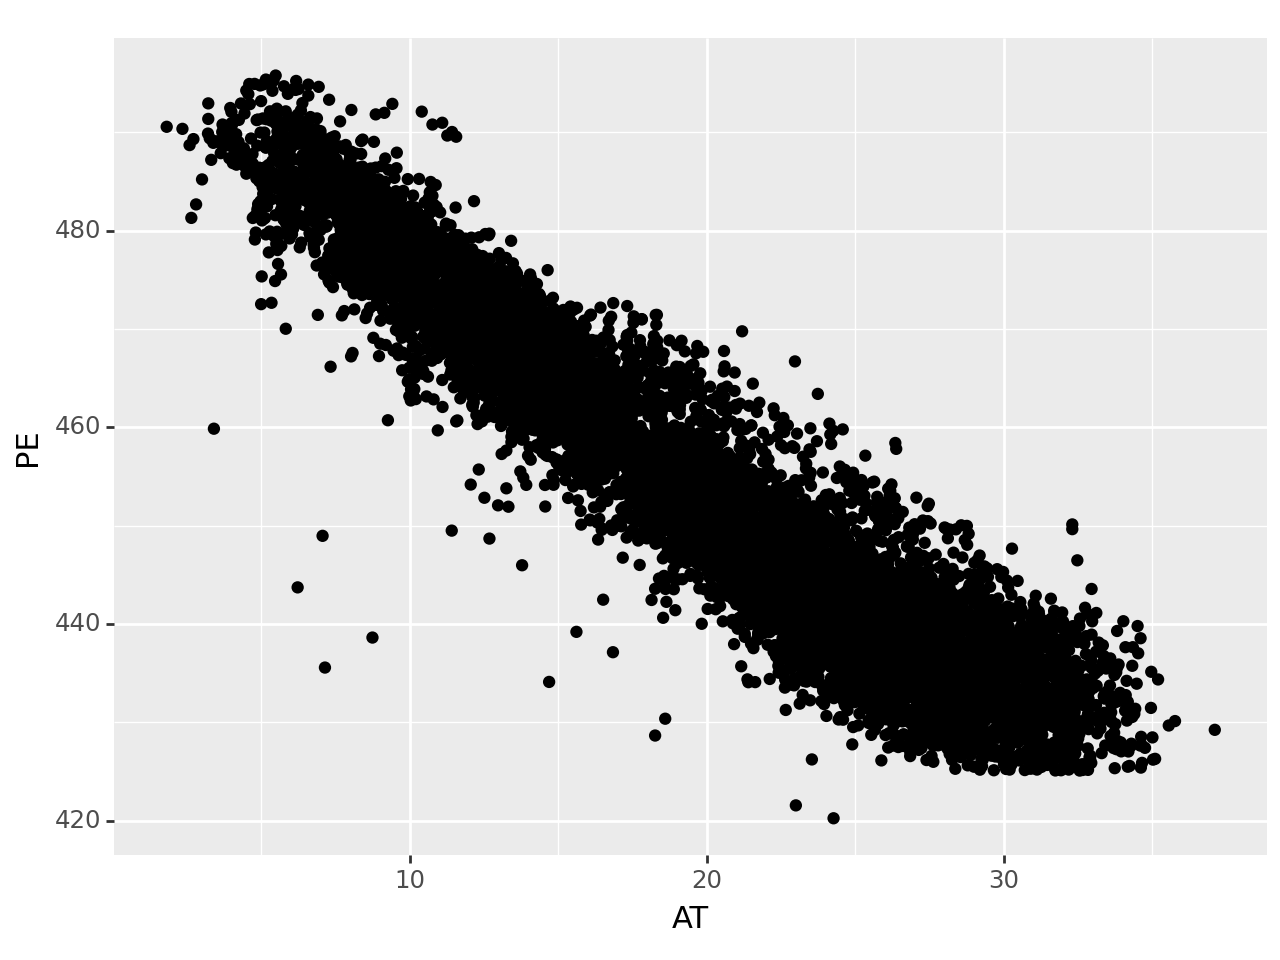

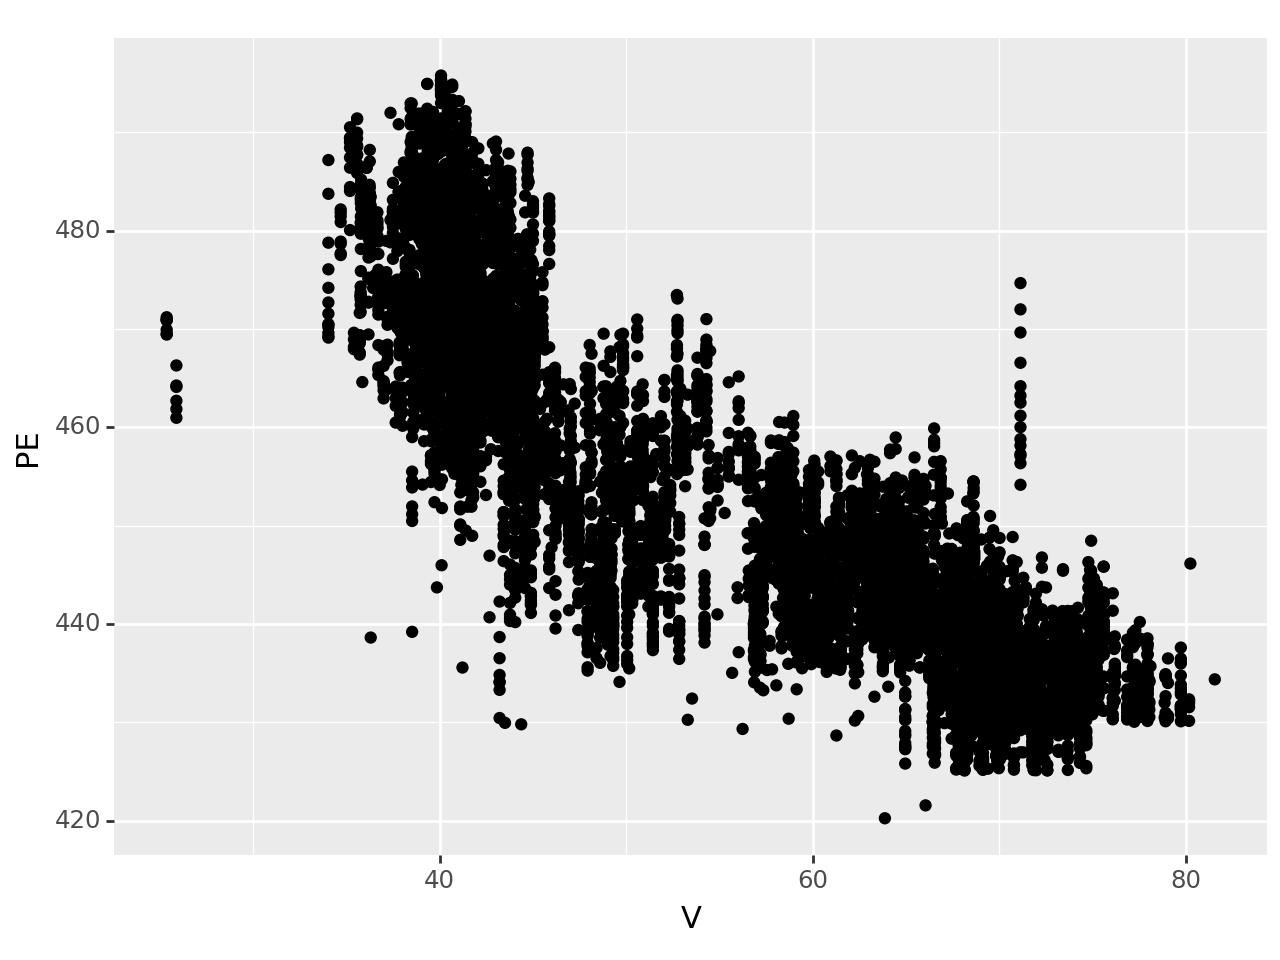

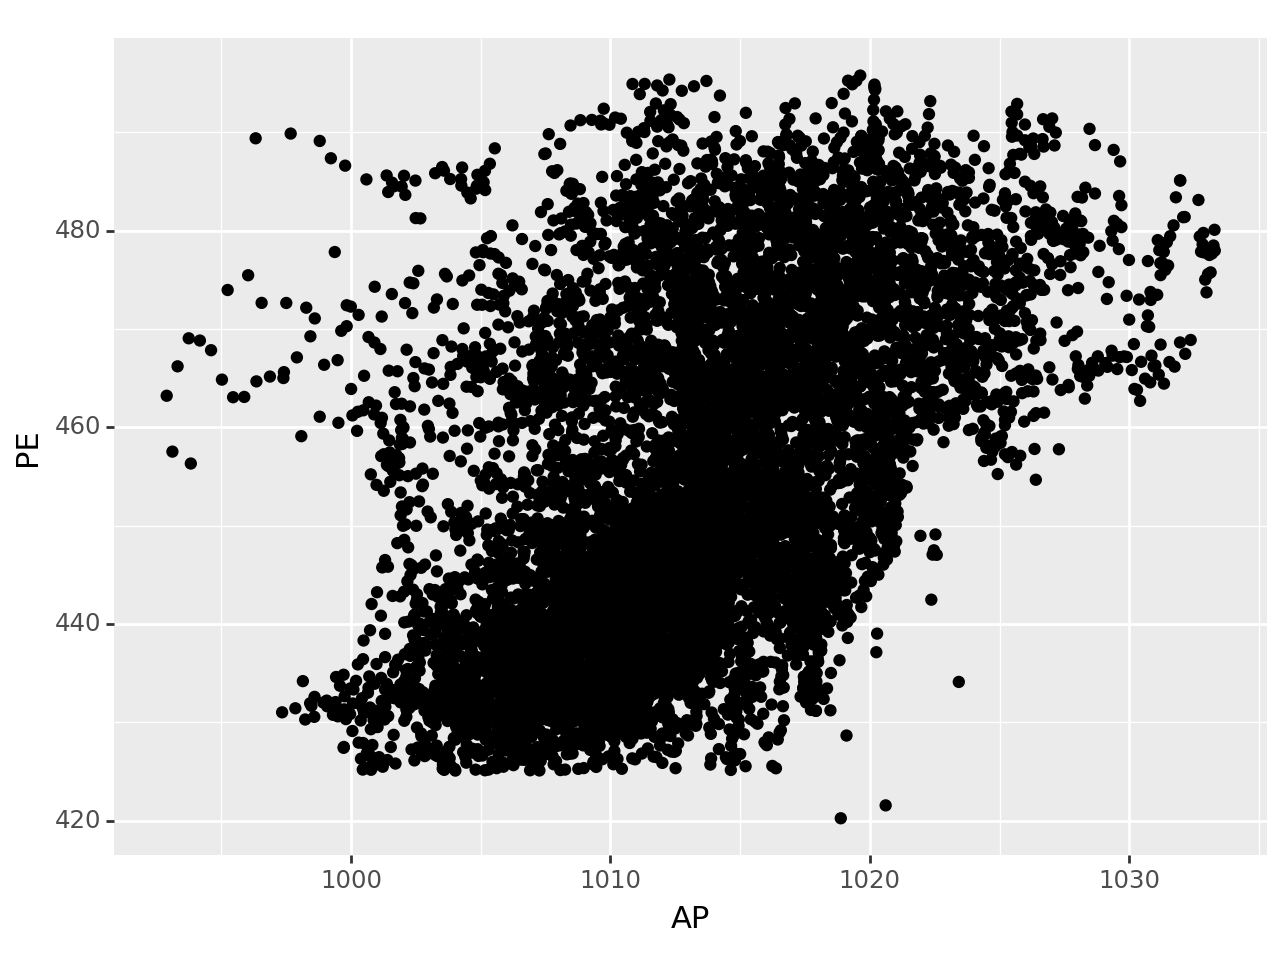

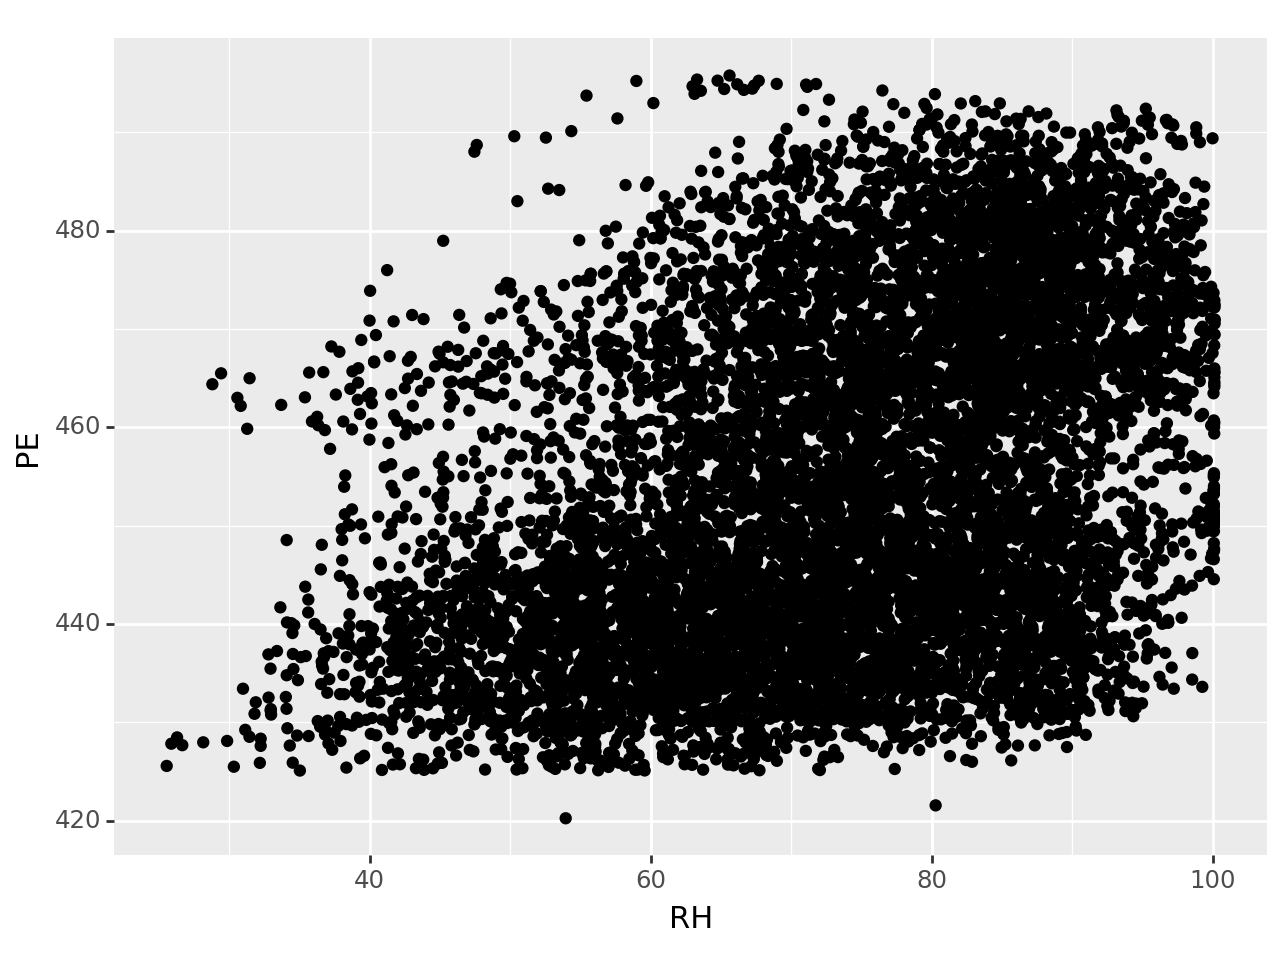

[<Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>,
 <Figure Size: (640 x 480)>]

In [391]:
columns = ccpp.columns[:-1] #everything but PE
scatterplots = [0]*len(columns)
for i, col in enumerate(columns):
    scatterplots[i] = (
        ggplot(ccpp) +
        aes(x=col, y='PE') +
        geom_point()
    )
scatterplots

c. Compute a correlation matrix for the 5 variables in the plot.  Are any of the potential explanatory variables linearly correlated with the output variable?  Does this match what you assumed in (b)?

Are any of the variables correlated with one another?

In [54]:
ccpp.corr()

# AT and V are well correlated with PE and with each other. 
# PE and AP have reasonable correlation.
# RH and AT have a reasonable correlation.
# Everything else (below |0.5|) is a weak correlation.

,AT,V,AP,RH,PE
AT,1.000000,0.844107,-0.507549,-0.542535,-0.948128
V,0.844107,1.000000,-0.413502,-0.312187,-0.869780
AP,-0.507549,-0.413502,1.000000,0.099574,0.518429
RH,-0.542535,-0.312187,0.099574,1.000000,0.389794
PE,-0.948128,-0.869780,0.518429,0.389794,1.000000


d. Use ordinary least squares (and ```statsmodels``` to develop a model relating the power plant output to each of the single variables. 

In general, we can formulate a hypothesis about the coefficients of such a model.  the most common test of a linear regression model is the hypothesis that $H_1$ : There is some relationship between $X$ and $Y$, i.e. $\beta_1 \ne 0$.  Based on the outputs, do you accept these hypotheses (because you rejected the null hypothesis $\beta_1 =0$ for each of the four values? 


In [383]:
import statsmodels.formula.api as sm

model = sm.ols(formula="PE ~ AT + V + AP + RH", data=ccpp)
params = model.fit().params
params
# accept hypothesis for AT, V, and RH

Intercept    454.609274
AT            -1.977513
V             -0.233916
AP             0.062083
RH            -0.158054
dtype: float64

e. The $R^2$ statistic of regression quantifies the fraction of total variance in the outcome variable explained by the model.  It is defined as 

$$R^2 = \frac{\text{TSS} - \text{RSS}}{\text{TSS}}$$

where TSS is the total sum of squares,

$$\text{TSS} = \sum (y_i - \bar{y})^2$$

and RSS is the residual sum of squares, ie the sum of the squares of the residuals that we calculated in class.   $R^2$ ranges between 0 and 1, with 1 being a perfect model.  

What are the $R^2$ values for each of these models? Which is the best model at explaining the outcome

In [384]:
if not 'intercept' in ccpp.columns:
    ccpp.insert(0, "intercept", 1)
    columns = ccpp.columns[:-1]
# broadcast parameter multiplication with columns and then do TSS and RSS
TSS = np.sum(np.square(ccpp["PE"] - ccpp["PE"].mean()))
RSS = np.sum(np.square(ccpp["PE"] - model.fit().predict(ccpp[columns])))
r2 = (TSS - RSS)/TSS
r2

0.9286960898122536

f.  There are 6 possible 2-factor linear models for the data, 4 possible 3-factor models and 1 that includes all 4 factors.  Use ordinary least squares to compare these models.  Which gives the best explanation?  

Given that the a more complex model is subject to noise, do you feel that adding more factors to the model is worth the improvement in explanatory performance?

In [381]:
from itertools import combinations
variables = ('AT', 'V', 'AP', 'RH') #possible variables
r2 = {} # set up r^2 dictionary
perms_generator = (combinations(variables, i) for i in range(2,5)) #possible unique permutations
for perms in perms_generator: # iterate through every permutation
    for perm in perms:
        model = sm.ols(formula=f'PE ~ {"+".join(perm)}', data=ccpp) # get model
        params = tuple(model.fit().params) # get params of model
        params += (0, )*(len(variables) - len(perm)) # ex. (1, 2) --> (1, 2, 0, 0, 0) (helps with broadcasting)
        TSS = np.sum(np.square(ccpp["PE"] - ccpp["PE"].mean()))
        RSS = np.sum(np.square(ccpp["PE"] - model.fit().predict(ccpp[columns])))
        r2[perm] = 1 - RSS/TSS # get r2 value

dict(sorted(r2.items(), key=lambda item: item[1], reverse=True)) # sort dictionary by value

## for this particular model, the optimal model uses just AT and V which achieves
## an r^2 value of 0.908, while (AT, V, P) and (AT, V, AP, RH) have a r^2 of 
## 0.91 and 0.92 respectively, which is a negligible gain compared to the complexity of the model
## which supports the conclusion from our original correlation matrix

{('AT', 'V', 'AP', 'RH'): 0.9286960898122537,
 ('AT', 'V', 'RH'): 0.928374821658302,
 ('AT', 'AP', 'RH'): 0.9210025307676986,
 ('AT', 'RH'): 0.9209480760095282,
 ('AT', 'V', 'AP'): 0.9179754458602664,
 ('AT', 'V'): 0.9157294412114197,
 ('AT', 'AP'): 0.9008123274074772,
 ('V', 'AP', 'RH'): 0.8039581703127988,
 ('V', 'AP'): 0.786925962684559,
 ('V', 'RH'): 0.7720133685892465,
 ('AP', 'RH'): 0.3842741215943508}

## Sampling probabilities

In class, we discussed the idea of collecting data from a population as a sample, a random chance.

We can sample to collect data in real life, and we can also use sampling as a useful way to estimate quantities.

Let's consider a deck of cards that has 13 ranks (A-10,J,Q,K) and 4 suits (clubs, diamonds, hearts, spades) for a total of 52 cards.

(a) We can simulate drawing from the deck with a computer program.  Write a Python function that takes an argument $n$ and each time it is called, returns a random set of $n$ cards as a dataframe with one card in each row described by the card's rank (one column) and suit (a second column).

In [261]:
ranks = ('A', ) + tuple(str(i) for i in range(2, 11)) + ('J', 'Q', 'K')
suits = tuple(('clubs', 'diamonds', 'hearts', 'spades'))

def draw(num_sim, num_cards):
    rank = np.random.choice(ranks, size=(num_sim, num_cards))
    suit = np.random.choice(suits, size=(num_sim, num_cards))
    
    if num_cards == 1: 
        return pd.DataFrame({
            'rank' : rank,
            'suit' : suit 
        })
    else:
        return (rank, suit)

(b) We can use your function to simulate the probability of a specific event happening.  For example, the probability of drawing a card that is either clubs or spades as a suit and either a 3, 4, 5 or 6 is $\frac{1}{2}\cdot\frac{4}{13} = \frac{2}{13}$.  Draw 10,000 random cards and determine how many are clubs or spades and either 3, 4, 5, or 6.  Check that this fraction is close to the expected probability.  

In [213]:
card_df = draw(10000)
filtered_df = card_df[
        card_df['suit'].isin(('clubs', 'spades')) & 
        card_df['rank'].isin(('3', '4', '5', '6'))
    ]
print(
    f'expected value: {2/13}',
    f'\nexperimental value: {len(filtered_df) / len(card_df)}'
)

expected value: 0.15384615384615385 
experimental value: 0.1529


(c) We can also use simulation to estimate probabilities that would be hard to calculate by hand.  For example, let's say you are playing a type of Poker where the goal is to get a pair of 3s and at least 4 diamonds in a 5 card hand.  Use a simulation to estimate the probability of being dealt such a hand.

In [262]:
num_sim = int(1e6)
hand_size = 5
hands, suits_drawn = draw(num_sim, hand_size)

count_both = np.sum(
    (np.sum(hands=='3', axis=1) >= 2) &
    (np.sum(suits_drawn=='diamonds', axis=1) >= 4)
)
prob_both = count_both/num_sim
prob_both

0.000754

(d) Use the same method -- if you are dealt 5 cards, what is the probabilty the highest card is a 10?  What about if you are dealt 7 cards? 

Test your code to learn a bit about the variance, and what happens if you change the sample size.

In [393]:
sim_size = (1e3, 1e4, 1e5, 1e6)
# # fig, axs = plt.subplots(len(sim_size), 1)
# # for ax, sim in zip(axs, sim_size):
# for sim in sim_size:
#     num_sim = int(sim)
#     num_cards = 5 
#     order = {rank : i for i, rank in enumerate(ranks)}
#     hands, _ = draw(num_sim, hand_size)
#     del _
#     highest = np.fromiter( #seems to take the same time as list --> array conversion
#         (max(hand, key=lambda x: order.get(x)) for hand in hands), 
#         dtype='U2'
#     )
#     print(
#         f'experimental value: {np.sum(highest=="10") / num_sim}'
#     )
#     unique_high_ranks, unique_high_count = np.unique(
#         highest, 
#         return_counts=True
#     )
#     #resort by rank
#     unique_high_ranks = sorted(unique_high_ranks, key=lambda x: order.get(x)) #sort by rank
#     unique_high_count = unique_high_count[ # sort based on rank permutation
#         np.argsort(unique_high_ranks) #gets the original permutation by the original sort of U2
#     ]
#     # using plt instead of ggplot because dataframe would take up space
#     plt.bar(unique_high_ranks, unique_high_count, tick_label=unique_high_ranks)
#     plt.show()

import random

def high_card_hand(hand_size, highest, num_sim):
    count = 0
    for _ in range(num_sim):
        suits, ranks = [], []

        while len(suits) < hand_size:
           # talked with luke and realized I was overcomplicating the assignment 
            suits.append(random.randint(1, 4)) 
            ranks.append(random.randint(1, 13))

        ranks = sorted(ranks)
        count += (ranks[-1] == highest)

    probability = count / num_sim
    return probability

for sim in sim_size:
    probability = high_card_hand(5, 10, int(sim))
    print(probability)

0.103
0.1058
0.10885
0.10996


In [394]:
# for i in sim_size:
#     num_cards = 7
#     num_sim = int(i)
#     hands, _ = draw(num_sim, hand_size)
#     del _
#     highest = np.fromiter( #seems to take the same time as list --> array conversion
#         (max(hand, key=lambda x: order.get(x)) for hand in hands), 
#         dtype='U2'
#     )
#     print(
#         f'experimental value: {np.sum(highest=="10") / num_sim}'
#     )
#     unique_high_ranks, unique_high_count = np.unique(
#         highest, 
#         return_counts=True
#     )
#     #resort by rank
#     unique_high_ranks = sorted(unique_high_ranks, key=lambda x: order.get(x)) #sort by rank
#     unique_high_count = unique_high_count[ # sort based on rank permutation
#         np.argsort(unique_high_ranks) #gets the original permutation by the original sort of U2
#     ]
#     # using plt instead of ggplot because dataframe would take up space
#     plt.bar(unique_high_ranks, unique_high_count, tick_label=unique_high_ranks)
#     plt.show()
for sim in sim_size:
    probability = high_card_hand(7, 10, int(sim))
    print(probability)

0.085
0.0815
0.08343
0.082745


## Collecting fair samples (540.605 only)

Many of you may use microscopy in your work.  One common means of analysis is to look at object size.

Let's say you are looking at oval objects in images

We'll consider some random images that look as follows

In [7]:
import numpy as np
import matplotlib.pyplot as plt


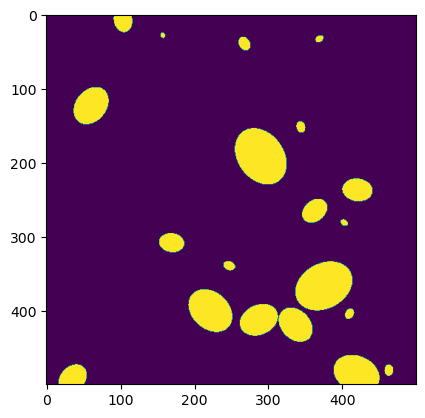

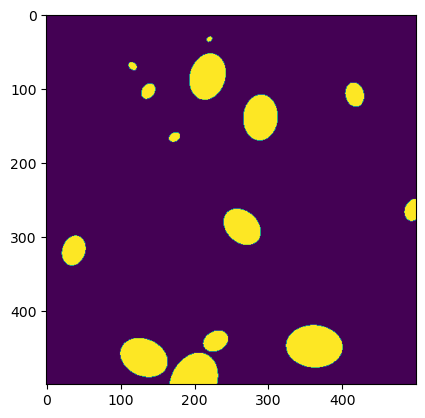

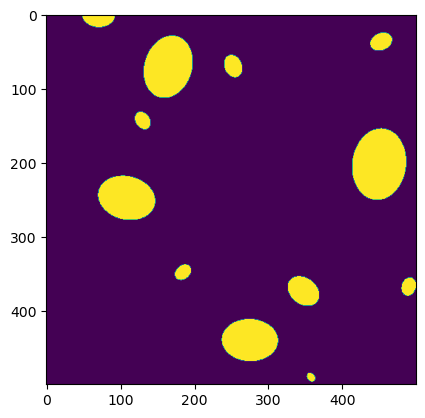

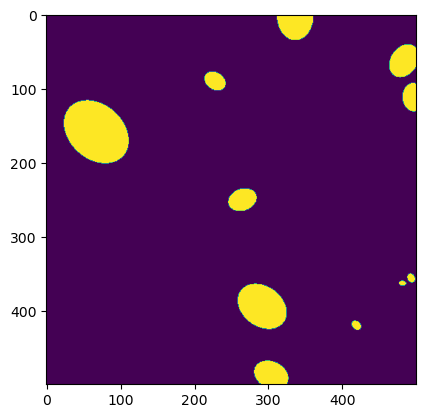

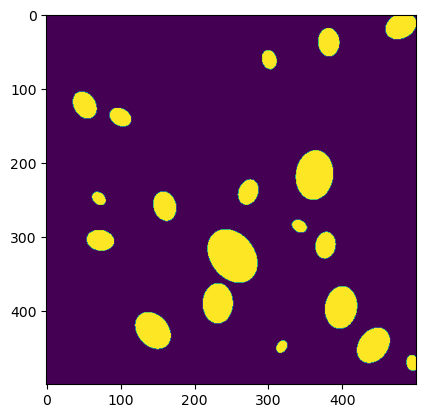

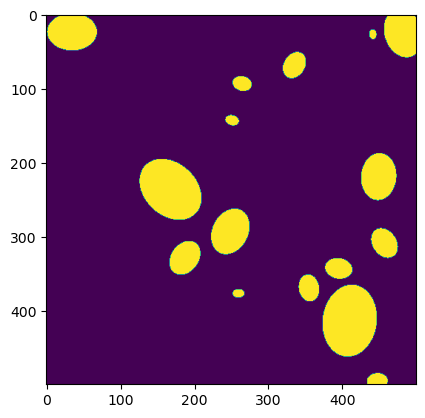

In [8]:
im_data = np.load('image_data.dat')
for i in range(6 ):
    plt.figure()
    plt.imshow(im_data[i])

You can see that most of the vesicles are in the field of view.  So it might make sense to just count those and ignore those that overlap the edges.

To see what effect that would have, let's look at a series of data that is a set of ovals, and their areas and whether they are fully in view or not in the dataframe ```shape_data``` that you can load from the file ```shapes_data_by_image.csv```

a) Load the shape_data.  Use a histogram to look at the areas of all of the on image shapes.  

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 77'. Pick better value with 'binwidth'.


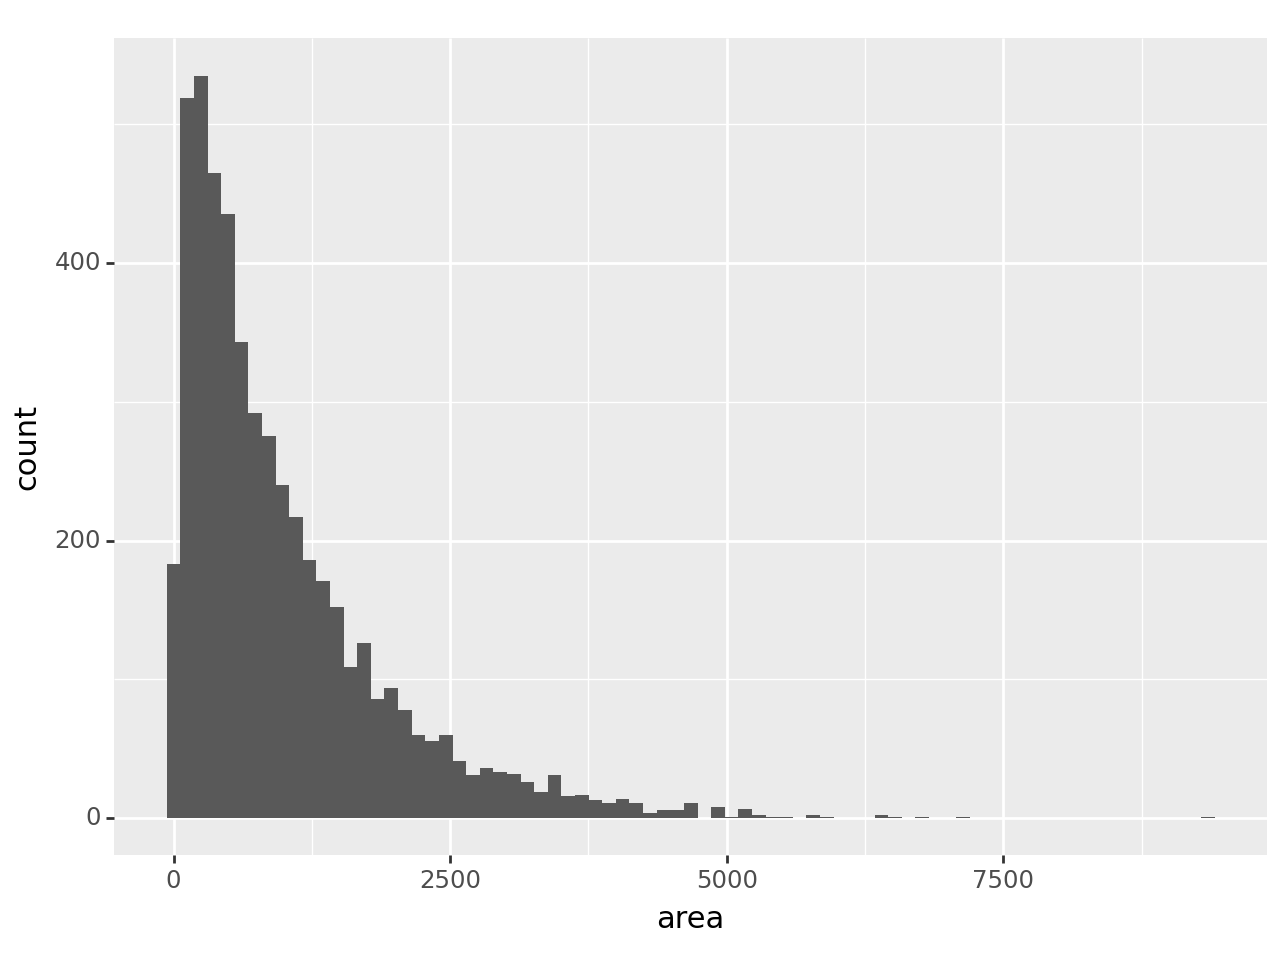

<Figure Size: (640 x 480)>

In [9]:
shape_data = pd.read_csv("shapes_data_by_image.csv")

def on_image_filt(df):
    return df[df["on_image"] == True]

(
    ggplot(shape_data.pipe(on_image_filt)) +
    aes(x='area') +
    geom_histogram()
)

b) Calculate the mean area of the shapes on the image. 

In [10]:
shape_data.pipe(on_image_filt)["area"].mean()

998.1945513076386

c)  These shapes were computationally generated. For comparison, let's take a look at a large sample of all generated shapes, whether they are off image or not.  Load that data from ```shapes_data_all.csv```.

In [11]:
shapes_data_all = pd.read_csv("shapes_data_all.csv")

d) Plot the histogram of these area.  Do they look similar to those that were on the images?  

/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 98'. Pick better value with 'binwidth'.


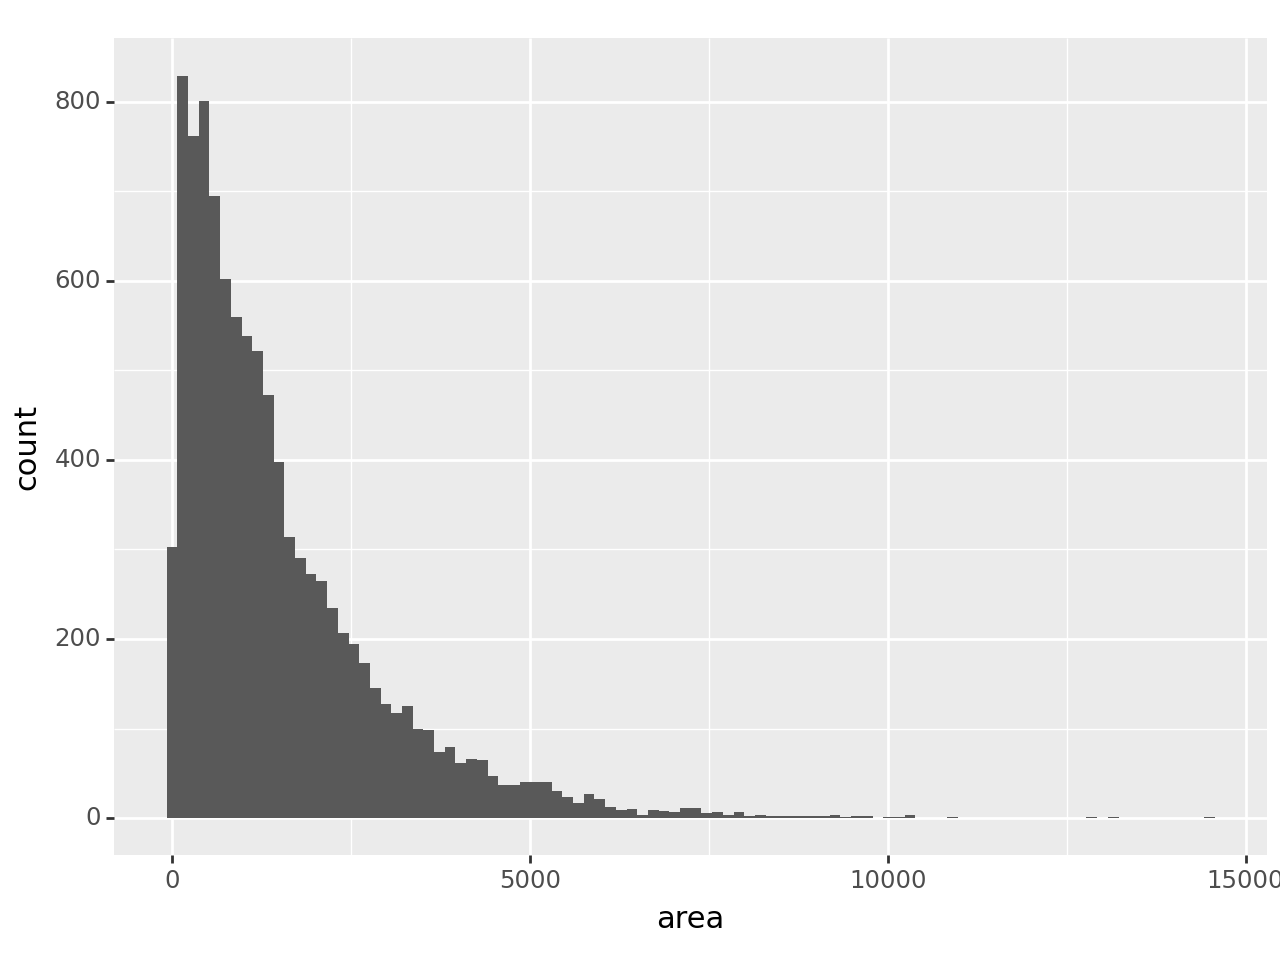

<Figure Size: (640 x 480)>

In [12]:
(
    ggplot(shapes_data_all) +
    aes(x='area') +
    geom_histogram()
)

the histograms look almost identitical in shape

e) Calculate the mean and median areas from the two data sets.  What is the change in the mean you report by excluding off image data?  Why do you think this is?

In [13]:
def get_areastats(df):
    return (df["area"].mean(), df["area"].median())
print(shape_data.pipe(on_image_filt).pipe(get_areastats))
print()
print(shapes_data_all.pipe(get_areastats))
# smaller mean and median for the on_image data. By virtue of size, smaller vesicles are more likely to be on screen
# and the ones cut off are more likely to be the larger areas. A probable reason to our observation. 

(998.1945513076386, 705.3315196421992)

(1522.6032942180186, 1096.0160591664905)


f) One fix for this problem is to observe that on average, a shape off the image is half off the image.  So if that is the case, you should be able to correct for this fact by taking an average of the all of the areas of the shapes on the image and twice the areas of the shapes that are partially off the image.  Compare the mean produced using this method to the mean of all shapes.  Does it match?

In [14]:
def off_image_filt(df):
    return df[df["on_image"] == False]
mu1 = shape_data.pipe(on_image_filt)["area"].mean()
mu2 = shape_data.pipe(off_image_filt)["area"].mean() * 2
(mu1 + mu2)/2

1575.814925813333

g) Compare the histograms produced by the data "adjusted" using the method in f to the data that data from all shapes.  Are they similar?  Were you able to recover the actual distribution using this method? Why or why not? 

/tmp/ipykernel_808605/3492367368.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/vivek/miniconda3/envs/schulman/lib/python3.10/site-packages/plotnine/stats/stat_bin.py:109: PlotnineWarning: 'stat_bin()' using 'bins = 140'. Pick better value with 'binwidth'.


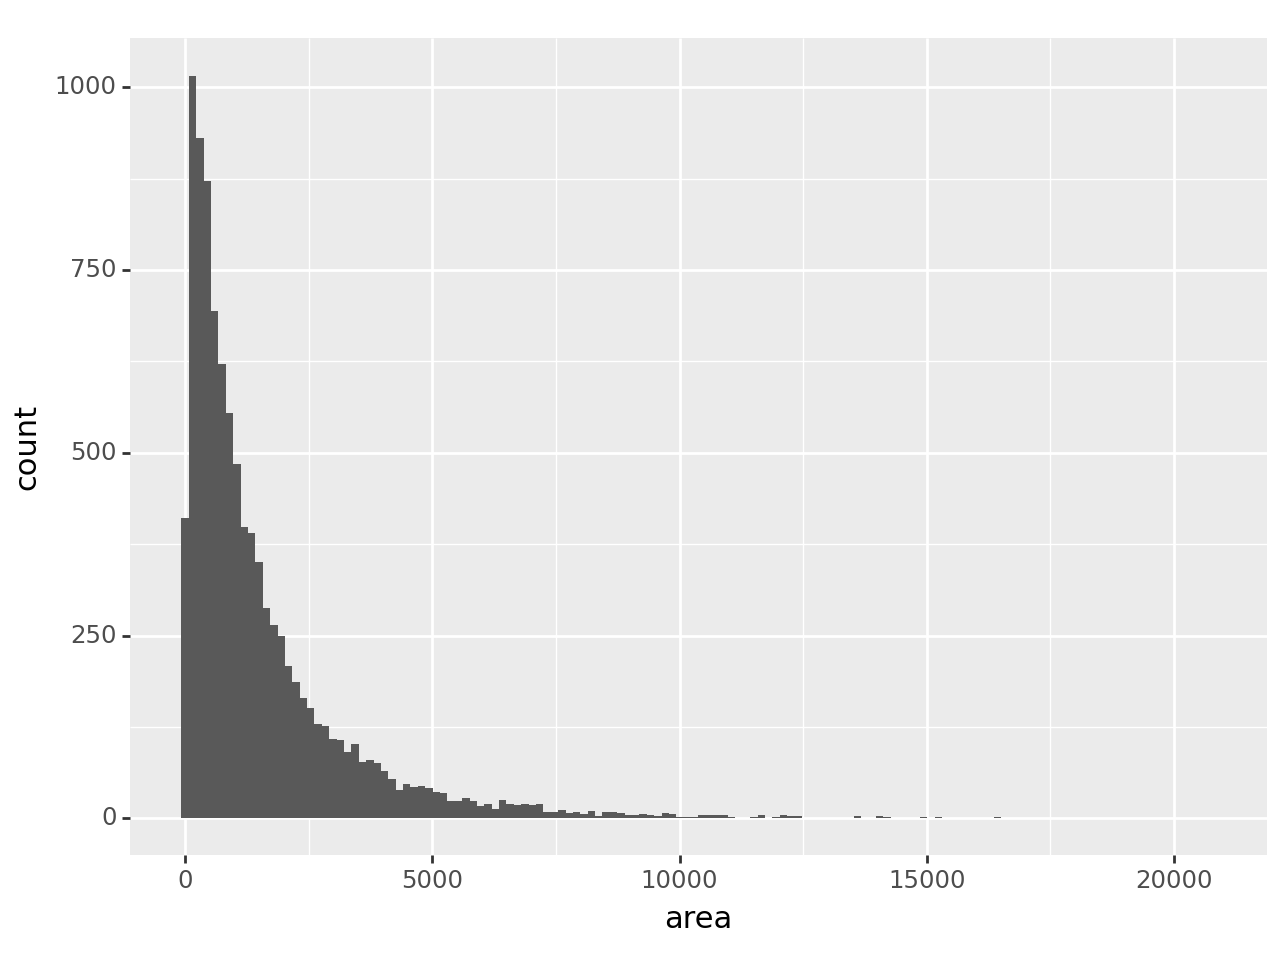

<Figure Size: (640 x 480)>

In [15]:
off_image_mod = shape_data.pipe(off_image_filt)
off_image_mod["area"] *= 2
shape_data_mod = pd.concat([shape_data.pipe(on_image_filt), off_image_mod])
(
    ggplot(shape_data_mod) +
    aes(x='area') +
    geom_histogram()
)

# mean recovered, but spread of data not recovered. The modified version has a narrower spread than the original data. 
# Most likely, a lot of the areas cut off image are less than 50% of the original area, so multiplying by 2 does not recover the original size. 

## Statistical mechanical sampling (540.605 only)

diffusion -- probability of diffusing to certain locations or probability of two molecules colliding

You probably remember that molecules in water undergo Brownian motion.  We can use random sampling to estimate learn about how diffusion works.

Briefly, we can write a "diffusive process" in one dimenision using : 

$$x(t + \Delta t) = x(t) + \sqrt{2 \Delta t D} Z$$

where 
- $x(t)$ the position of the particle at time $t$
- $\Delta t$ is a small value 
- $D$ is a diffusion constant
- $Z$ is a normally distributed random variable with mean 0 and standard deviation 1

a) Write a Python function that takes a value $\Delta t$, a final time $t_{final}$, and a diffusion constant $D$ as inputs and returns the displacement of the particle by $t_{final}$.

In [336]:
def displacement(D, delta_t, t_f):
    return np.sqrt(2 * t_f * D) * np.random.normal() #based on modification by schulman

b) Write a Python function that takes an argument $d$ and simulates a particle until it reaches a distance at least $d$ from its initial position and returnst the time at which it moved at least distance $d$ away.  
Use this function to genearate 10 samples of the time it takes for a particle with diffusion constant $D = 25 $ $\mu m^2/s$  to move at least 100 $\mu m$ from its initial position using $\Delta t = 0.0001 s$.

In [350]:
def simulate1D(d, D=25, delta_t=0.0001):
    disp = 0
    t = 0
    while disp < d:
        disp += (displacement(D, delta_t, t)) 
        t += delta_t
    return t
sim1D = tuple(simulate1D(100) for _ in range(10))
sim1D

(0.2626999999999874,
 0.08240000000000133,
 0.36569999999997604,
 0.22599999999999143,
 0.3495999999999778,
 1.1286999999998921,
 0.2890999999999845,
 0.12490000000000255,
 0.23549999999999038,
 1.3428999999998685)

c)  We can simulate diffusive motion in two-d using simultaneous equations:

$$x(t + \Delta t) = x(t) + \sqrt{2 \Delta t D} Z $$
$$y(t + \Delta t) = y(t) + \sqrt{2 \Delta t D} Z $$

Extend your function in b) to sample the time it takes to move 100 $\mu m$ from an initial position in a 2-dimensional diffusion process. Generate 10 samples.

In [351]:
def simulate2D(d, D=25, delta_t=0.0001):
    disp = 0
    t = 0
    x, y = 0, 0
    while disp < d:
        x += (displacement(D, delta_t, t)) 
        y += displacement(D, delta_t, t)
        disp = np.linalg.norm((x, y))
        t += delta_t
    return t

sim2D = tuple(simulate2D(100) for _ in range(10))
sim2D

(0.12470000000000254,
 0.1128000000000022,
 0.07650000000000116,
 0.12340000000000251,
 0.10410000000000195,
 0.11880000000000238,
 0.2353999999999904,
 0.07350000000000108,
 0.08730000000000147,
 0.1491999999999999)

d) Visualize the data from b) and c) using histograms.  What kind of distributions do you see?

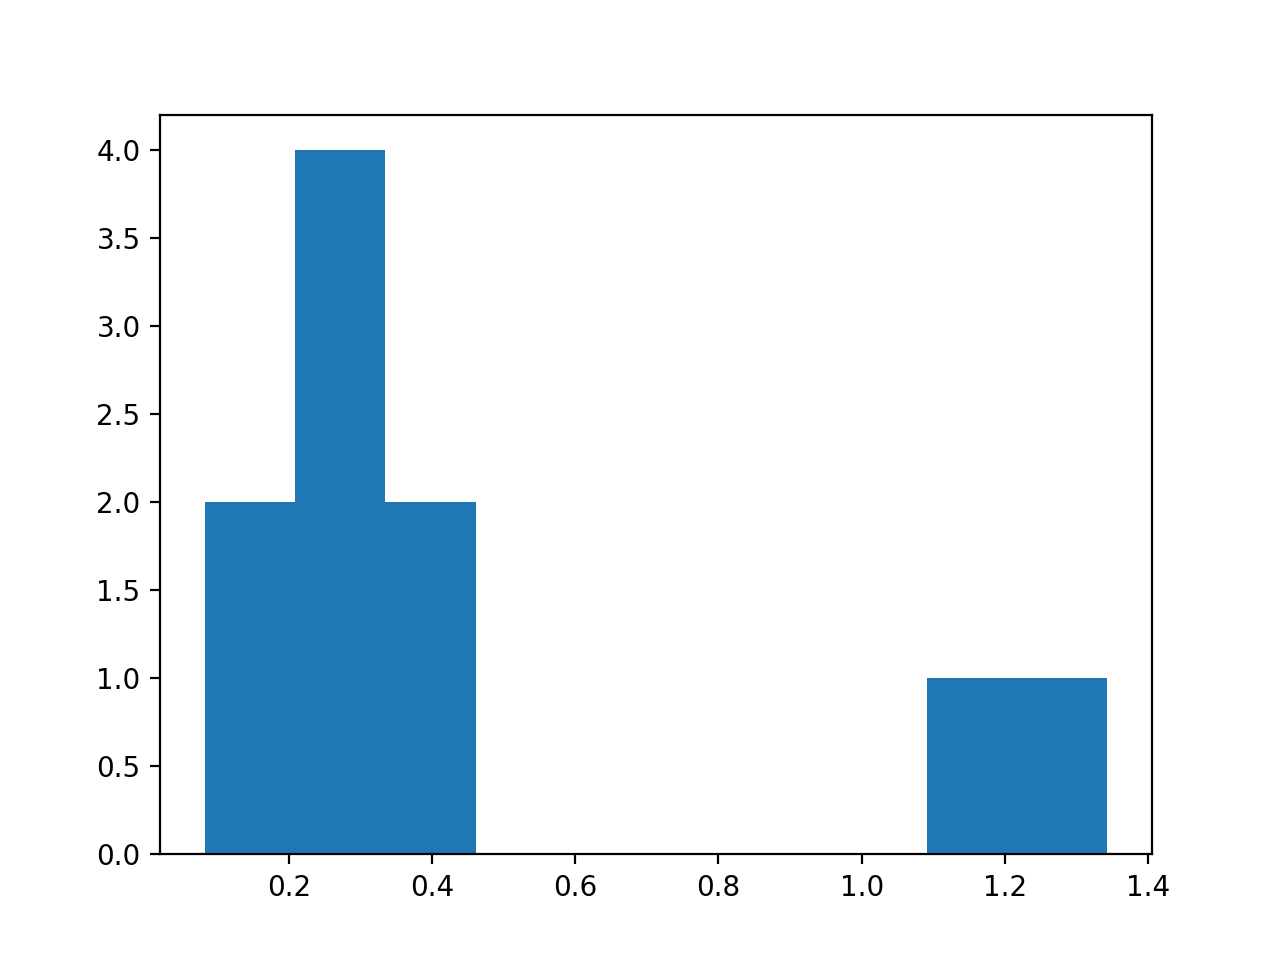

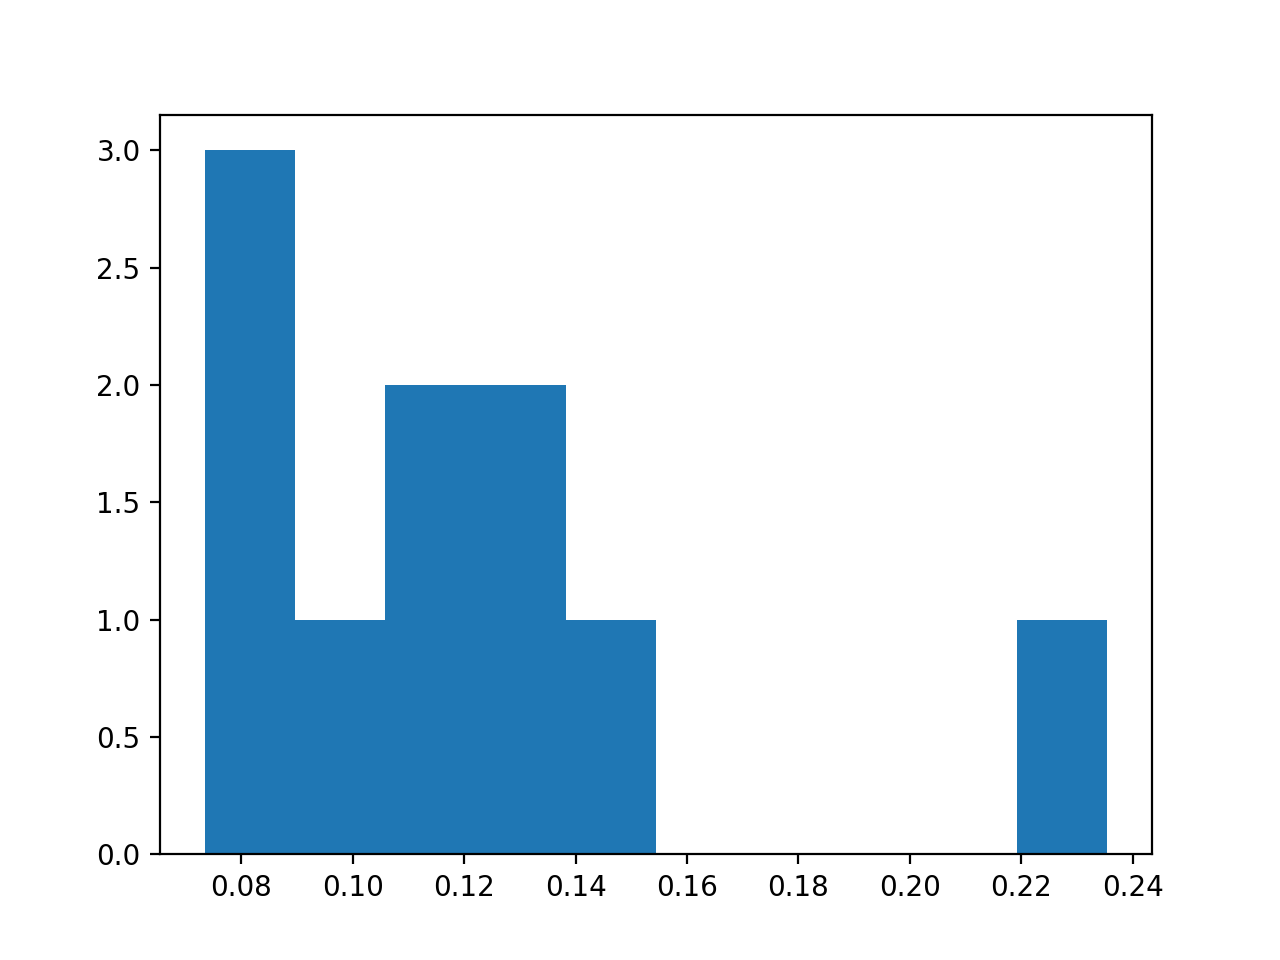

In [352]:
plt.hist(sim1D)
plt.show()
plt.hist(sim2D)
plt.show()

# hard to tell with so few samples, unable to gather a distribution from just this data.

e) Generate another 100 samples of times for the processes from b and c.  Now observe the distributions of times on a boxplot.  Which takes longer, escape in 1 or 2 dimensions? why?

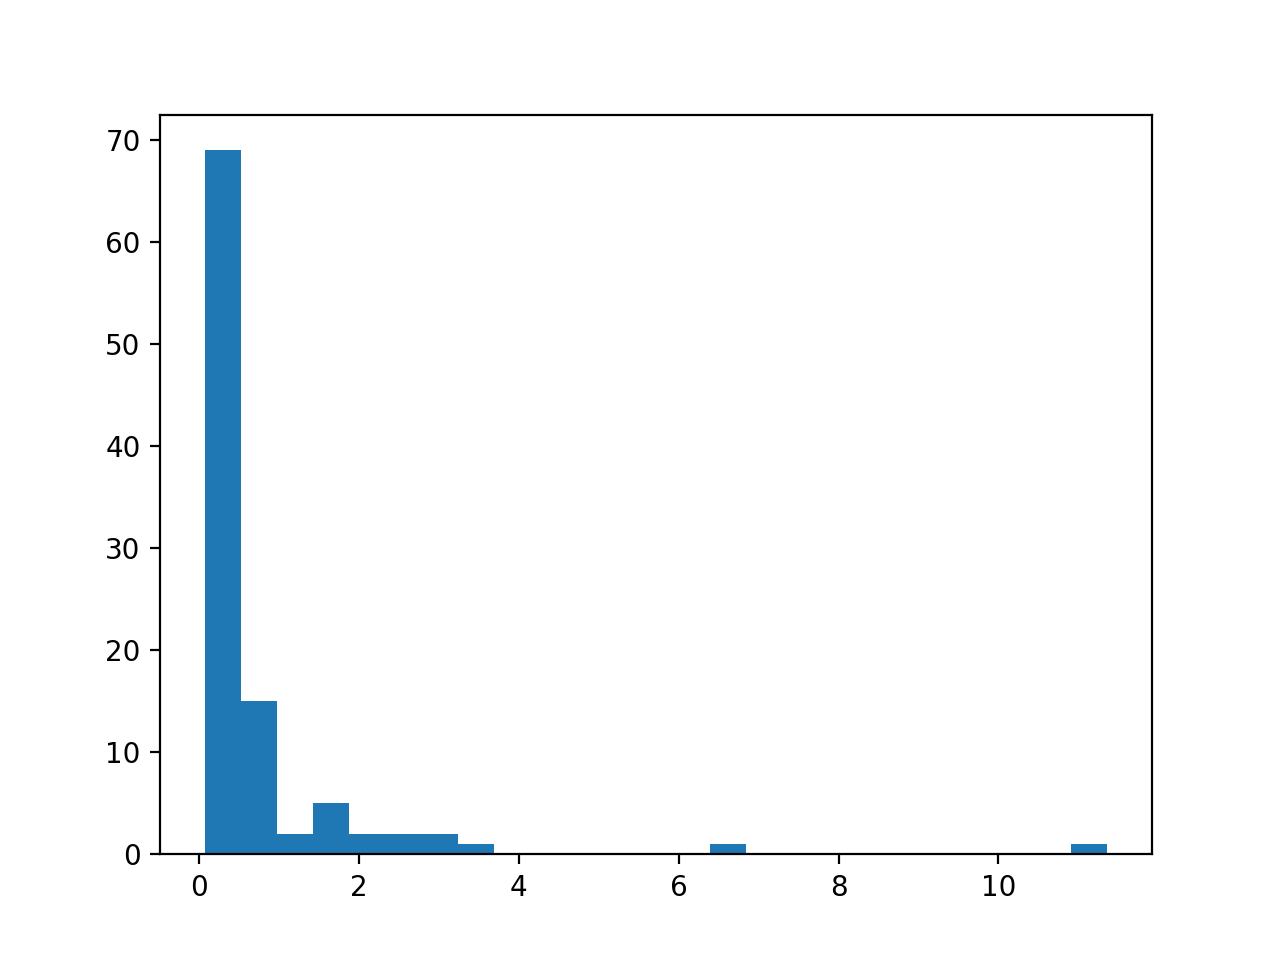

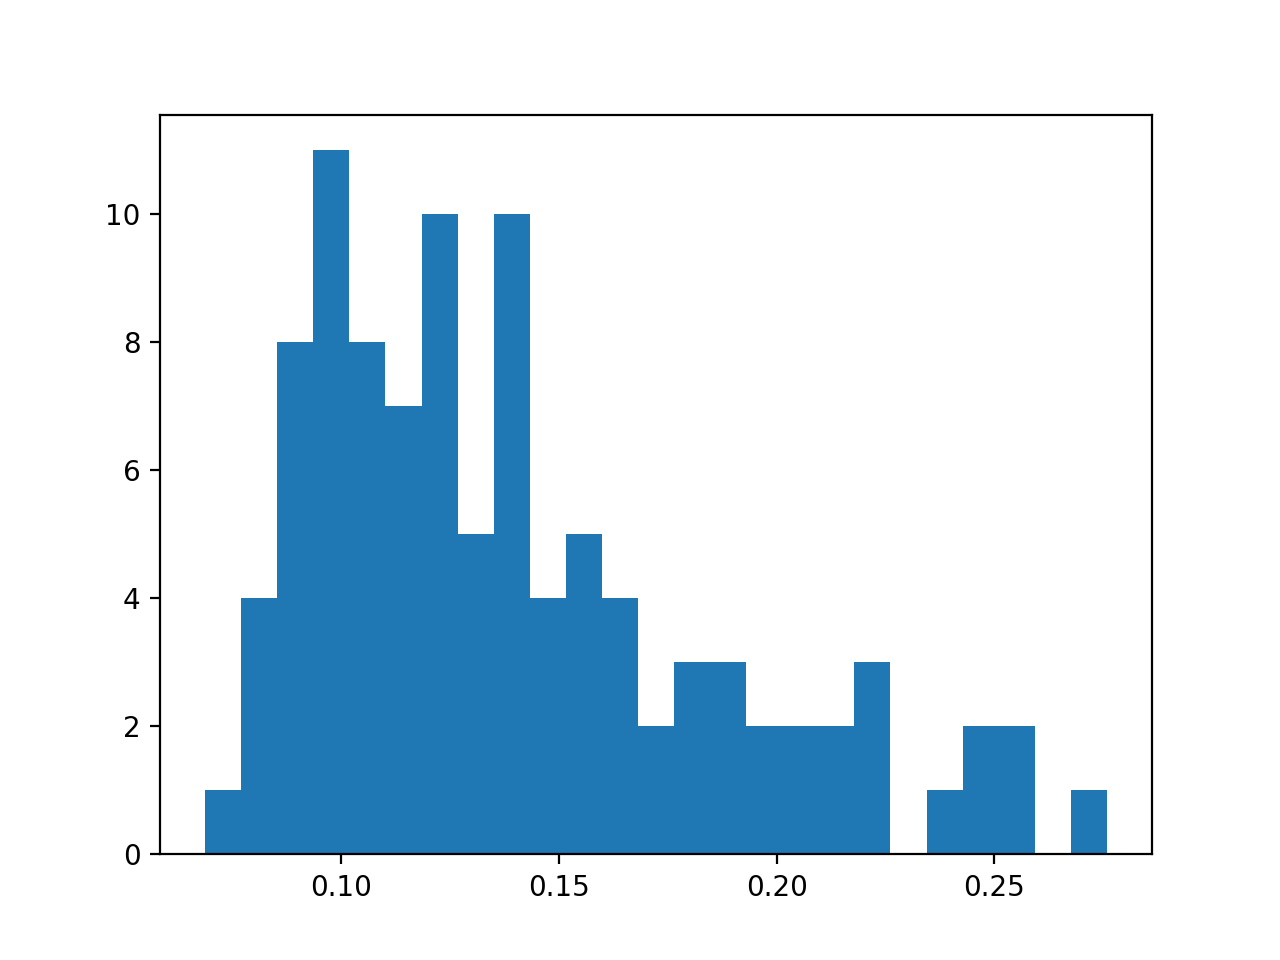

In [348]:
sim1D = tuple(simulate1D(100) for _ in range(100))
sim2D = tuple(simulate2D(100) for _ in range(100))

plt.hist(sim1D, bins=25)
plt.show()

plt.hist(sim2D, bins=25)
plt.show()
# approaches gaussian for 2d, but 1d looks like a possible gamma distribution. Severe outliers past 1 second in 1D case.
# takes longer in 1d case (definitely more extreme cases) because there are only 2 possible points of escape.
# in 2D case, there is a circular boundary of escape, so there are more potential paths to escape